In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import json
import torchvision
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import Subset, random_split
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import shutil
from pycocotools import mask as coco_mask
import os
import matplotlib.pyplot as plt

In [ ]:
# import os

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!git clone https://github.com/jasonfghx/retina_image.git

Cloning into 'retina_image'...
remote: Enumerating objects: 1690, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 1690 (delta 16), reused 0 (delta 0), pack-reused 1635 (from 2)
Receiving objects: 100% (1690/1690), 331.24 MiB | 23.94 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Updating files: 100% (1405/1405), done.


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [4]:
from ultralytics import YOLO

# Load a pretrained YOLO11n model
model = YOLO("yolo11n-seg.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.90M/5.90M [00:00<00:00, 76.4MB/s]


In [5]:
import cv2
import os
import numpy as np
os.makedirs('/content/retina_image/train')
os.makedirs('/content/retina_image/train/images')
os.makedirs('/content/retina_image/train/labels')

In [ ]:
add

In [9]:
import shutil
add=glob("/content/retina_image/s1/images/*jpg")
for i in add[:]:
  name=i.split("/")[-1]
  shutil.copy(i,'/content/retina_image/train/images/'+name)

In [10]:
def mask_to_yolo_polygon(mask_image_path, path):
    label_file = open("/content/retina_image/train/labels/" + str(path.replace('.png','')) + '.txt', 'a')
    mask = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)
    h, w = mask.shape[0], mask.shape[1]
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #, 0.5, positive_orientation='low'

    for contour in contours:
        if len(contour) == 4 :continue
        # print(len(contour))
        label_file.write('0')
        label_file.write(' ')
        for cont in contour:
            label_file.write(str(cont[0][0] / w))
            label_file.write(' ')
            label_file.write(str(cont[0][1] / h))
            label_file.write(' ')
        label_file.write('\n')
    label_file.close()

for path in os.listdir("/content/retina_image/s1/masks"):
    # print(path)
    mask_image_path = "/content/retina_image/s1/masks/" + str(path)
    mask_to_yolo_polygon(mask_image_path, path)

In [13]:
import yaml

d ={'train':"/content/retina_image/train",'val': '/content/retina_image/train',
    'test':'/content/retina_image/train','names':['d'],'nc':1}


with open('/content/retina_image/data.yaml', 'w') as f:
    yaml.dump(d, f)

In [2]:
from ultralytics import YOLO
model = YOLO("yolo11n-seg.pt")
# model =YOLO('/content/runs/segment/train2/weights/last.pt')

# Train the model
train_results = model.train(
    data="/content/retina_image/data.yaml",  # path to dataset YAML
    epochs=80,  # number of training epochs
    imgsz=640,batch=8,lr0=0.001, lrf=0.0005  # training image size
     # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/retina_image/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.0005, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

train: Scanning /content/retina_image/train/labels.cache... 93 images, 0 backgrounds, 0 corrupt: 100%|██████████| 93/93 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 520.5±102.3 MB/s, size: 64.7 KB)


val: Scanning /content/retina_image/train/labels.cache... 93 images, 0 backgrounds, 0 corrupt: 100%|██████████| 93/93 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/80       1.5G      3.484       5.79      4.838      3.019         16        640: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]

                   all         93         97    0.00179      0.515    0.00187   0.000434          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/80      2.31G      2.849      4.331      4.583       2.47         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.60it/s]


                   all         93         97    0.00262      0.753     0.0237    0.00639   3.58e-05     0.0103   1.83e-05   1.83e-06

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/80      2.31G       2.58      3.458       4.02      2.261          6        640: 100%|██████████| 12/12 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


                   all         93         97    0.00269      0.773     0.0203    0.00425   0.000573      0.165     0.0304    0.00429

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/80      2.31G      2.441      3.279      3.727       2.11          9        640: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


                   all         93         97    0.00294      0.845     0.0849     0.0237   0.000215     0.0619    0.00124   0.000202

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/80      2.31G      2.274      3.019      3.509      1.923          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


                   all         93         97      0.105      0.186     0.0682     0.0138      0.052      0.103     0.0123    0.00168

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/80      2.31G      2.333      3.036      3.473      1.881         14        640: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


                   all         93         97       0.12      0.196     0.0936     0.0197      0.174      0.309       0.14     0.0228

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/80      2.33G      2.148      2.633      3.104      1.784          8        640: 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


                   all         93         97      0.255      0.412      0.224      0.056      0.209       0.33      0.109      0.015

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/80      2.35G      2.297      2.755      3.111      1.893          9        640: 100%|██████████| 12/12 [00:03<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


                   all         93         97      0.175      0.361      0.136     0.0428      0.131      0.299     0.0646     0.0126

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/80      2.35G      2.285      2.637      3.051      1.896         11        640: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


                   all         93         97      0.152      0.423      0.138     0.0342      0.229      0.268      0.138      0.028

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/80      2.35G      2.237      2.636      3.086      1.876          9        640: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


                   all         93         97      0.241       0.34       0.17     0.0389      0.236      0.392      0.191     0.0368

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/80      2.35G      2.118      2.662      3.091      1.757          4        640: 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.63it/s]

                   all         93         97      0.226      0.577      0.231     0.0699      0.291       0.34      0.179     0.0359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/80      2.36G      2.182      2.536      2.989      1.875          8        640: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]


                   all         93         97      0.199      0.278      0.149     0.0469     0.0577     0.0722      0.011    0.00162

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/80      2.36G      2.175      2.414      2.754      1.825         12        640: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]

                   all         93         97      0.116      0.423      0.101     0.0332      0.136      0.433      0.101     0.0211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/80      2.36G      2.125       2.36      2.831      1.795         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


                   all         93         97        0.1      0.433     0.0886     0.0273      0.134      0.371     0.0923     0.0191

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/80      2.36G      2.055      2.247      2.775      1.764          5        640: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


                   all         93         97      0.272      0.412      0.247     0.0806      0.395      0.423      0.352     0.0739

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/80      2.36G      2.083       2.42      2.669      1.742          7        640: 100%|██████████| 12/12 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all         93         97      0.347      0.402      0.317      0.109      0.389      0.443      0.368     0.0764



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/80      2.36G      2.025      2.299      2.635      1.718         14        640: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]

                   all         93         97      0.322      0.381      0.292     0.0879      0.195      0.299      0.128     0.0217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/80      2.36G      2.001      2.302      2.598       1.68         12        640: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


                   all         93         97      0.353      0.454      0.329      0.103      0.315      0.299      0.224     0.0449

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/80      2.36G      2.004      2.362      2.503      1.755          7        640: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all         93         97      0.323      0.485      0.308     0.0874      0.267      0.536      0.247     0.0541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/80      2.38G      2.036      2.485      2.514      1.802          7        640: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


                   all         93         97      0.289      0.423      0.309     0.0851      0.398      0.578      0.452      0.102

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/80      2.38G      2.019      2.405      2.427      1.693          8        640: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


                   all         93         97      0.344      0.412      0.329     0.0843      0.389      0.498      0.382     0.0994

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/80      2.39G      1.937      2.417      2.438      1.642          9        640: 100%|██████████| 12/12 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all         93         97      0.338      0.474      0.298     0.0852      0.385      0.536      0.363      0.095



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/80      2.39G      1.964      2.349      2.263      1.619         11        640: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all         93         97      0.348      0.495      0.323     0.0957      0.365      0.495       0.36     0.0963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/80      2.39G      1.939      2.453      2.326       1.63          5        640: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


                   all         93         97      0.311      0.392       0.25     0.0768      0.322      0.392      0.245     0.0598

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/80      2.39G       1.92      2.248      2.226      1.641          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


                   all         93         97      0.329       0.49      0.283     0.0927      0.209      0.268       0.13      0.023

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/80      2.39G      1.879      2.241      2.318      1.626          9        640: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


                   all         93         97      0.445      0.485      0.405      0.115      0.234      0.216      0.144     0.0227

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/80      2.39G      1.872      2.194      2.083      1.565          8        640: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]


                   all         93         97      0.461      0.567       0.48      0.181      0.406      0.423      0.377     0.0823

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/80      2.39G      2.019      2.253       2.15      1.646          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]


                   all         93         97      0.466      0.646       0.51      0.212      0.472      0.577      0.503      0.127

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/80      2.39G      1.938       2.27      2.185       1.61         10        640: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


                   all         93         97       0.48      0.542      0.456      0.162      0.381      0.433      0.284     0.0441

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/80      2.39G      1.837       2.17      2.013       1.59         12        640: 100%|██████████| 12/12 [00:02<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]


                   all         93         97      0.407      0.732      0.446      0.155       0.31      0.515      0.278     0.0577

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/80      2.39G      1.875      2.135       1.99      1.554         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


                   all         93         97      0.526      0.652      0.589      0.264      0.549       0.68      0.616      0.209

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/80      2.39G      1.852      2.187      2.118      1.536          7        640: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


                   all         93         97      0.522      0.649      0.611      0.236      0.524      0.722      0.605      0.193

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/80      2.39G        1.8       2.18      2.054      1.606          8        640: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


                   all         93         97      0.466      0.619       0.49      0.165      0.484       0.68      0.499      0.141

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/80      2.39G      2.003      2.267      2.189      1.667         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


                   all         93         97      0.448      0.526      0.416      0.143      0.447      0.588      0.426      0.127

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/80      2.39G      1.873      2.127      1.996      1.566          6        640: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


                   all         93         97      0.373      0.588      0.394      0.154      0.417      0.629      0.463      0.145

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/80      2.39G      1.849      2.395      1.977      1.577         12        640: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


                   all         93         97      0.445      0.637      0.483      0.165      0.462      0.639      0.512      0.147

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/80      2.39G      1.749      2.237       1.92       1.51         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


                   all         93         97      0.529       0.67      0.584      0.222      0.521      0.711      0.572      0.157

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/80      2.39G      1.856      2.213      1.882      1.563         10        640: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


                   all         93         97      0.585      0.701       0.65      0.226      0.568       0.68      0.628      0.192

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/80      2.39G      1.757      2.107      1.877      1.511          7        640: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


                   all         93         97      0.554      0.601      0.597      0.229      0.533      0.598      0.558      0.147

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/80      2.39G      1.785      2.067      1.837      1.458          9        640: 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


                   all         93         97      0.577      0.649      0.647      0.249      0.574      0.654      0.628      0.166

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/80      2.39G      1.903      2.242      1.969      1.561         11        640: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


                   all         93         97      0.644      0.753      0.712      0.285      0.643      0.726      0.702      0.196

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/80      2.39G      1.772      2.102       1.84      1.457         10        640: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


                   all         93         97      0.697      0.691      0.733        0.3      0.639      0.629       0.65      0.159

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/80      2.39G       1.77      2.245      1.892      1.487         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


                   all         93         97      0.658      0.693      0.712      0.287      0.659      0.698      0.699      0.176

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/80      2.39G      1.675      2.014      1.913       1.48         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


                   all         93         97      0.674      0.726      0.743      0.316      0.676      0.754      0.736      0.232

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/80      2.39G      1.757      2.104      1.687      1.487         10        640: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.07it/s]

                   all         93         97        0.6      0.732      0.694        0.3       0.68      0.773      0.739      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/80      2.39G      1.686      2.098      1.767      1.499          9        640: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


                   all         93         97      0.607      0.765      0.706      0.297      0.651      0.674      0.715      0.217

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/80      2.39G        1.8       2.24      1.818      1.533         12        640: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


                   all         93         97      0.679      0.786      0.769      0.346      0.677      0.784       0.76      0.245

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/80      2.39G      1.689      1.981       1.69      1.443          8        640: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all         93         97      0.734      0.701       0.77      0.373      0.712       0.68      0.736      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/80      2.39G      1.672      2.136      1.733      1.472          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


                   all         93         97      0.697      0.763      0.751      0.356      0.674      0.742      0.745      0.254

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/80      2.39G      1.707      2.066      1.718      1.474         12        640: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

                   all         93         97      0.771       0.66      0.781      0.362       0.73      0.696      0.746      0.264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      51/80      2.39G      1.732      1.974      1.679      1.476         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all         93         97      0.769      0.732      0.804      0.378      0.747      0.763      0.797      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      52/80      2.39G      1.734      1.974      1.735        1.5         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


                   all         93         97      0.749      0.784        0.8      0.385      0.749      0.784      0.798      0.276

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      53/80      2.39G      1.704      2.152      1.644      1.445         11        640: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


                   all         93         97      0.802      0.711       0.79      0.392      0.777      0.718      0.769      0.304

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      54/80      2.39G      1.758      2.381      1.664      1.516          7        640: 100%|██████████| 12/12 [00:02<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all         93         97      0.761      0.722      0.806      0.404      0.782      0.742       0.79      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      55/80      2.39G      1.632      1.971      1.694      1.432         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


                   all         93         97      0.802      0.773      0.819      0.404      0.816      0.794      0.813      0.319

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      56/80      2.39G      1.699      2.164      1.648      1.453          7        640: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


                   all         93         97      0.751      0.773      0.815        0.4      0.803      0.804      0.828      0.315

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      57/80      2.39G      1.621      2.118       1.53      1.395         15        640: 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all         93         97      0.741      0.824      0.819      0.422       0.77      0.835      0.819      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      58/80      2.39G      1.572       2.03      1.583      1.355          7        640: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


                   all         93         97      0.741      0.824       0.81      0.407      0.758      0.839      0.815      0.269

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      59/80      2.39G       1.63      2.025      1.621      1.432          8        640: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


                   all         93         97      0.754      0.825       0.85      0.429      0.795      0.845       0.86      0.287

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      60/80      2.39G      1.575      1.918      1.443       1.42         12        640: 100%|██████████| 12/12 [00:02<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all         93         97      0.828      0.841      0.857      0.448      0.845      0.842      0.865      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      61/80      2.39G      1.581      2.021      1.589      1.385         15        640: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


                   all         93         97      0.825      0.856      0.867      0.472      0.856      0.825      0.863      0.318

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      62/80      2.39G      1.595      2.105      1.584      1.399         10        640: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


                   all         93         97      0.832      0.825      0.843      0.461       0.83      0.814      0.846      0.305

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      63/80      2.39G      1.509      1.967      1.424      1.349         11        640: 100%|██████████| 12/12 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


                   all         93         97      0.747      0.845      0.826      0.452      0.738      0.835      0.808      0.277

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      64/80      2.39G      1.586      1.949      1.655      1.418          9        640: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


                   all         93         97      0.784      0.863      0.854      0.458      0.757      0.856      0.821      0.303

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      65/80      2.39G      1.513      1.875       1.44      1.365         13        640: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


                   all         93         97      0.898      0.866      0.908      0.482      0.865      0.859      0.888      0.341

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      66/80      2.39G      1.496      1.988      1.391      1.319         11        640: 100%|██████████| 12/12 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]


                   all         93         97      0.838      0.845       0.89      0.494      0.837      0.848      0.879      0.348

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      67/80      2.39G      1.523      2.079      1.527      1.347          8        640: 100%|██████████| 12/12 [00:02<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


                   all         93         97      0.834      0.887      0.909      0.508      0.816      0.868      0.871      0.361

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      68/80      2.39G      1.454      1.856      1.385      1.344          9        640: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


                   all         93         97      0.816      0.876      0.905      0.518      0.809      0.874      0.873      0.353

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      69/80      2.39G      1.485      1.895      1.439      1.355          4        640: 100%|██████████| 12/12 [00:02<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


                   all         93         97      0.809      0.874      0.906      0.503      0.792      0.856      0.874      0.341

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      70/80       2.4G      1.577      1.934      1.503      1.389          8        640: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


                   all         93         97      0.831      0.864      0.906      0.494      0.814      0.856      0.874      0.325
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      71/80       2.4G      1.572      1.714      1.599      1.529          5        640: 100%|██████████| 12/12 [00:03<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]

                   all         93         97      0.822      0.907       0.92      0.501       0.82      0.907      0.891      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      72/80       2.4G       1.62      1.783      1.616      1.593          4        640: 100%|██████████| 12/12 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


                   all         93         97      0.867      0.876      0.924       0.49      0.862      0.876      0.892      0.351

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      73/80       2.4G      1.648      1.775      1.689      1.602          5        640: 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all         93         97      0.874      0.866      0.909      0.487      0.885      0.872       0.91      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      74/80       2.4G      1.679      1.669      1.542      1.578          5        640: 100%|██████████| 12/12 [00:02<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


                   all         93         97      0.869      0.845      0.898      0.483      0.893      0.866      0.909      0.361

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      75/80       2.4G      1.569      1.781      1.674      1.527          5        640: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


                   all         93         97      0.826      0.881      0.901      0.502      0.826      0.881      0.897       0.36

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      76/80       2.4G      1.566      1.605      1.535      1.511          5        640: 100%|██████████| 12/12 [00:02<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]

                   all         93         97      0.833      0.875       0.91       0.52      0.808      0.867      0.897      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      77/80       2.4G      1.558      1.611      1.568      1.515          4        640: 100%|██████████| 12/12 [00:02<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


                   all         93         97      0.835      0.887       0.92      0.525      0.816      0.867       0.88      0.357

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      78/80       2.4G      1.542      1.568      1.465      1.477          5        640: 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


                   all         93         97      0.841      0.874      0.919      0.524      0.855      0.835       0.88      0.354

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      79/80       2.4G      1.599      1.663      1.577      1.572          5        640: 100%|██████████| 12/12 [00:02<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]


                   all         93         97      0.868      0.866      0.918      0.529      0.861      0.856      0.905      0.354

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      80/80       2.4G      1.509      1.613      1.464      1.471          5        640: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


                   all         93         97      0.873      0.866      0.918      0.528      0.863      0.856      0.906       0.35

80 epochs completed in 0.100 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.0MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/6 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  17%|█▋        | 1/6 [00:00<00:01,  2.54it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 2/6 [00:01<00:02,  1.73it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


                   all         93         97      0.868      0.866      0.917      0.528      0.859      0.856      0.904      0.355
Speed: 0.4ms preprocess, 6.9ms inference, 0.0ms loss, 12.0ms postprocess per image
Results saved to runs/segment/train


In [8]:
results = model(source="/content/retina_image/s1/images/Stage_1_ROP_36.jpg", imgsz=640)
  # 顯示結果
# results.save()


image 1/1 /content/retina_image/s1/images/Stage_1_ROP_36.jpg: 640x640 3 ds, 29.2ms
Speed: 16.1ms preprocess, 29.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
from ultralytics import YOLO
model = YOLO("/content/runs/detect/train3/weights/last.pt")


In [ ]:
results = model(source="/content/retina_image/train/images/11.png", imgsz=640)

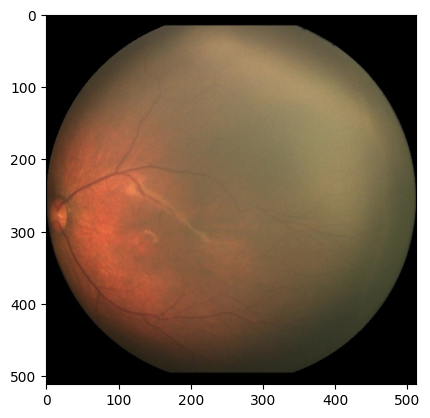

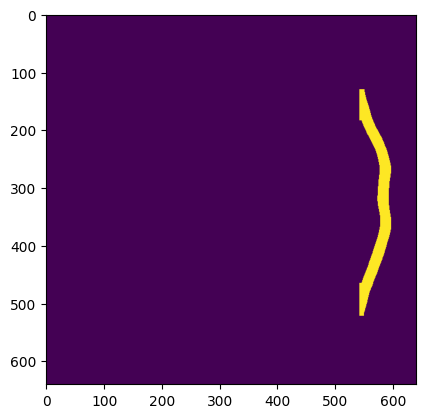

In [7]:
# plt
import matplotlib.pyplot as plt
plt.imshow(results[0].orig_img[:,:,::-1])
plt.show()
plt.imshow(results[0].masks.data.cpu().numpy()[0])
plt.show()